In [1]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload
import re
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /jobfs/135369232.gadi-pbs/matplotlib-x2sx6yg_ because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [59]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import climate_utils

In [57]:
xr.set_options(display_expand_attrs=False)

In [19]:
from dask.distributed import Client, wait
# client.close()
client = Client(n_workers=50, threads_per_worker=1, memory_limit=None) 
client

2025-02-16 19:42:07,978 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker.py", line 1250, in heartbeat
    response = await retry_operation(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/utils_comm.py", line 459, in retry_operation
    return await retry(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/utils_comm.py", line 438, in retry


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 50
Total threads: 50,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32977,Workers: 50
Dashboard: /proxy/8787/status,Total threads: 50
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46509,Total threads: 1
Dashboard: /proxy/39003/status,Memory: 0 B
Nanny: tcp://127.0.0.1:44379,


2025-02-16 21:09:18,409 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:41825' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('transpose-ba483119890fb7a2baa7bced6086d1d0', 0, 0, 7, 4), ('transpose-ba483119890fb7a2baa7bced6086d1d0', 0, 0, 11, 3), ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 11, 6), ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 5, 8), ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 8, 10), ('transpose-ba483119890fb7a2baa7bced6086d1d0', 0, 0, 5, 5)} (stimulus_id='handle-worker-cleanup-1739700558.408541')
2025-02-16 21:09:18,424 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:33089' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 11, 10), ('transpose-ba483119890fb7a2baa7bced6086d1d0', 0, 0, 9, 10), ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 8, 7), ('transpose-ba4831

# Pre-processing (mergine into one zarr and resmample)

In [69]:
from glob import glob

In [20]:
LE_PATH = '/g/data/v45/nxm561/cesm1_lens/Amon/tas'
#'tas_Amon_CESM1-CAM5_historical_rcp45_r10i1p1_192001-208012_g025.nc')

In [21]:
# file_list = os.listdir(LE_PATH)

In [70]:
file_list = glob(os.path.join(LE_PATH, '*rcp85*.nc'))

In [72]:
len(file_list)

81

In [73]:
file_list[:-3]

['/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r21i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_CESM1-CAM5_hist_rcp85_r26i1p1_192001-210012.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_CESM1-CAM5_hist_rcp85_r32i1p1_192001-210012.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r15i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r11i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_CESM1-CAM5_hist_rcp85_r31i1p1_192001-210012.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r13i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r8i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_CESM1-CAM5_hist_rcp85_r23i1p1_192001-210012.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp

In [74]:
# Full paths
file_paths = [os.path.join(LE_PATH, f) for f in file_list]

# Regex to extract ensemble member (e.g., r21i1p1)
def extract_member(filename):
    match = re.search(r'r\d+i\d+p\d+', filename)
    return match.group(0) if match else None

# Open datasets individually, add member coordinate, and store them in a list
ds_list = []
for file in file_paths:
    member = extract_member(file)
    ds = xr.open_dataset(file) #, chunks='auto')#={'time':-1, 'lon':144//12, 'lat':72//12})
    ds = ds.assign_coords(member=member).expand_dims('member')
    ds_list.append(ds['tas'])

# Concatenate along the 'member' dimension
ds_combined = xr.concat(ds_list, dim='member').chunk(
    {'member': -1, 'time':-1, 'lon':144//12, 'lat':72//12}) 

In [75]:
# ds_combined = ds_combined['tas']a

In [76]:
ds_combined

<xarray.DataArray 'tas' (member: 81, time: 3012, lat: 72, lon: 144)> Size: 20GB
dask.array<xarray-<this-array>, shape=(81, 3012, 72, 144), dtype=float64, chunksize=(81, 3012, 6, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 24kB 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * member   (member) <U7 2kB 'r21i1p1' 'r26i1p1' ... 'r28i1p1' 'r40i1p1'
    height   float64 8B 2.0
Attributes: (8)

In [77]:
ds_combined = ds_combined.drop_vars('height', errors='ignore')

In [78]:
ds_combined = client.scatter(ds_combined).result()

In [79]:
# ds_combined = ds_combined.chunk({'member': -1, 'time':-1, 'lon':144//12, 'lat':72//12}) 

In [80]:
# ds_combined = ds_combined.persist()
# wait(ds_combined)

In [81]:
ds_resamp_combined = ds_combined.resample(time='YE').mean()#.persist()
# wait(ds_resamp_combined)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


In [82]:
ds_resamp_combined = client.scatter(ds_resamp_combined).result()

In [83]:
ds_resamp_combined = ds_resamp_combined.persist()
wait(ds_resamp_combined)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 18.85 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 4, 10)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 1, 1)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 0, 9)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 5, 3)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 5, 9)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 1, 2)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 3, 9)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 10, 3)>, <Future: finished, type: numpy.ndarray, key: ('transpose-5ba950257ce89ae06ca2dcf37f385491', 0, 0, 6, 2)>, <Future: finishe

In [84]:
OUTPUT_FNAME = '/g/data/w40/ab2313/time_of_emergence/cesm1_lens_tas_2.zarr'

In [85]:
ds_resamp_combined.to_zarr(OUTPUT_FNAME, mode='w')

# Opening Data

In [ ]:
import my_stats

In [86]:
FILE_NAME = '/g/data/w40/ab2313/time_of_emergence/cesm1_lens_tas_2.zarr'

In [87]:
LE_CESM_CHUNKS = {'member': -1, 'time':-1, 'lon':144//6, 'lat':72//12}

In [127]:
le_ds = xr.open_dataset(FILE_NAME, engine='zarr', chunks=LE_CESM_CHUNKS)['tas']

In [128]:
le_ds = le_ds.sel(time=le_ds.time.dt.year>1920)

In [129]:
le_ds_base_period = le_ds.where(le_ds.time.dt.year.isin(np.arange(1920, 1950)), drop=True).mean(dim='time')

In [131]:
le_anom_ds = le_ds - le_ds_base_period

In [132]:
le_smean_ds = climate_utils.weighted_lat_lon_mean(le_anom_ds).compute()

In [133]:
# le_smean_ds = le_smean_ds.sel(time=le_ds.time.dt.year>1920)

## S/N Ratio

In [134]:
le_smean_signal_ds = xr.apply_ufunc(
    my_stats.apply_lowess, 
    le_smean_ds,#.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    kwargs=dict(window=41),
    vectorize=True, 
    dask='parallelized',    
).compute()

In [135]:
le_smean_detrend_ds = le_smean_ds - le_smean_signal_ds

In [136]:
ds_smean_sn_lowess = le_smean_signal_ds/le_smean_detrend_ds.std(dim='time')

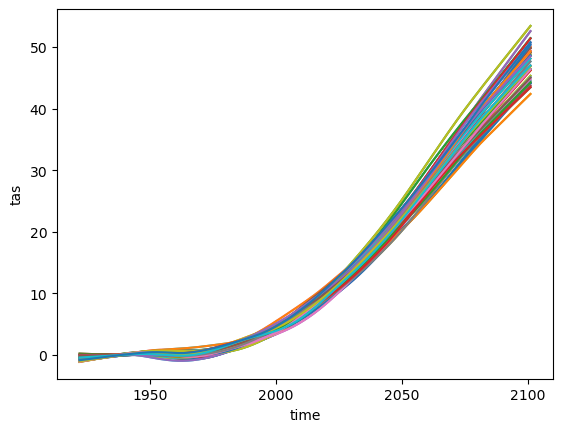

In [140]:
ds_smean_sn_lowess.plot(hue='member', add_legend=False);

In [143]:
import time_of_emergence_calc as toe

(array([ 2.,  0.,  0.,  0.,  0., 12., 26., 19.,  8., 14.]),
 array([1959. , 1961.6, 1964.2, 1966.8, 1969.4, 1972. , 1974.6, 1977.2,
        1979.8, 1982.4, 1985. ]),
 <BarContainer object of 10 artists>)

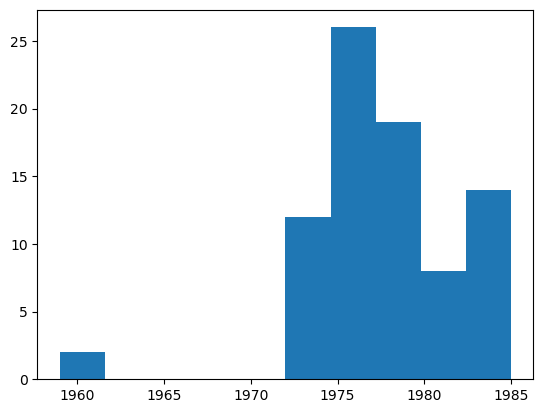

In [153]:
plt.hist(toe_sn_1)

## KS test

In [184]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [180]:
window = 30

In [181]:
data_ds_window = (le_smean_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                 ) 

base_period_window_ds = (le_smean_ds.where(le_smean_ds.time.dt.year.isin(np.arange(1920, 1950)), drop=True)
                         .rename({'time':'window_dim'})
                        )

In [185]:
%%time
# Expected 3 minutes 30 seconds - best
# 6 23 - era5
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 4.37 s, sys: 1.34 s, total: 5.7 s
Wall time: 4.36 s


In [198]:
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

## Comparisons

In [167]:
toe_sn_1 = toe.get_permanent_exceedance(ds_smean_sn_lowess, threshold=1, comparison_func=np.greater)
toe_sn_2 = toe.get_permanent_exceedance(ds_smean_sn_lowess, threshold=2, comparison_func=np.greater)
toe_sn_3 = toe.get_permanent_exceedance(ds_smean_sn_lowess, threshold=3, comparison_func=np.greater)

In [199]:
toe_ks = toe.get_permanent_exceedance(ks_ds, threshold=0.01, comparison_func=np.less)
toe_ttest = toe.get_permanent_exceedance(ttest_ds, threshold=0.01, comparison_func=np.less)

In [204]:
toe_sn_3 - toe_ks

<xarray.DataArray 'tas' (member: 81)> Size: 648B
array([19., 11., 27., 12., 12., 17., 21., 18., 11., 35., 19., 12., 12.,
       27., 14., 19., 13., 11., 15., 11., 15., 21.,  9., 19., 14., 16.,
       16., 11., 23., 17., 19., 11., 33., 13., 18., 11., 16., 12., 24.,
       10., 14., 23., 10., 19.,  9., 19., 19., 33., 11., 27., 24., 17.,
       19., 11., 10., 19., 14., 15., 10., 13.,  9., 35., 19., 17., 15.,
       12., 19., 12., 27., 17., 12.,  9., 16., 13., 12., 12., 12., 17.,
       11., 16., 16.])
Coordinates:
  * member   (member) <U7 2kB 'r21i1p1' 'r26i1p1' ... 'r28i1p1' 'r40i1p1'

In [175]:
np.std(toe_sn_1`), np.std(toe_sn_2), np.std(toe_sn_3)

(<xarray.DataArray 'tas' ()> Size: 8B
 array(4.4751341),
 <xarray.DataArray 'tas' ()> Size: 8B
 array(2.65486644),
 <xarray.DataArray 'tas' ()> Size: 8B
 array(2.24494555))

In [178]:
toe_sn_1.min(), toe_sn_1.max()

(<xarray.DataArray 'tas' ()> Size: 8B
 array(1959.),
 <xarray.DataArray 'tas' ()> Size: 8B
 array(1985.))

In [196]:
np.median(toe_ks), np.std(toe_ks)

(1977.0,
 <xarray.DataArray 'tas' ()> Size: 8B
 array(6.88957473))

In [174]:
np.median(toe_sn_1), np.median(toe_sn_2), np.median(toe_sn_3)

(1978.0, 1986.0, 1992.0)

In [201]:
x1, kde_toe_sn1 = toe.create_kde(toe_sn_1)
x2, kde_toe_sn2 = toe.create_kde(toe_sn_2)
x3, kde_toe_sn3 = toe.create_kde(toe_sn_3)

x4, kde_toe_ks = toe.create_kde(toe_ks)
x5, kde_toe_ttest = toe.create_kde(toe_ttest)

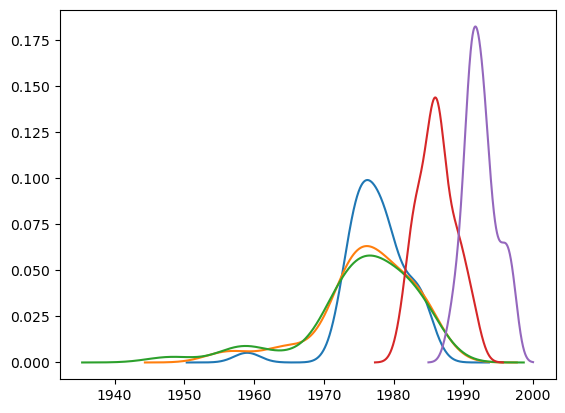

In [203]:
plt.plot(x1, kde_toe_sn1)
plt.plot(x4, kde_toe_ks)
plt.plot(x5, kde_toe_ttest)


plt.plot(x2, kde_toe_sn2)
plt.plot(x3, kde_toe_sn3)

# CEEMDAN

In [205]:
from PyEMD import CEEMDAN

In [206]:
ceedman = CEEMDAN(trials=500)

In [217]:
def return_residual(arr):

    imf_arr = ceedman(arr)

    return imf_arr[-1, :]

In [221]:
le_smean_ds.chunk({'member':1})

<xarray.DataArray 'tas' (member: 81, time: 180)> Size: 117kB
dask.array<xarray-<this-array>, shape=(81, 180), dtype=float64, chunksize=(1, 180), chunktype=numpy.ndarray>
Coordinates:
  * member   (member) <U7 2kB 'r21i1p1' 'r26i1p1' ... 'r28i1p1' 'r40i1p1'
  * time     (time) object 1kB 1921-12-31 00:00:00 ... 2100-12-31 00:00:00

In [225]:
imf_ds = xr.apply_ufunc(
    return_residual,
    le_smean_ds.chunk({'member':1}),
    input_core_dims=[['time']], 
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=['float']
)

In [226]:
imf_ds = imf_ds.compute()

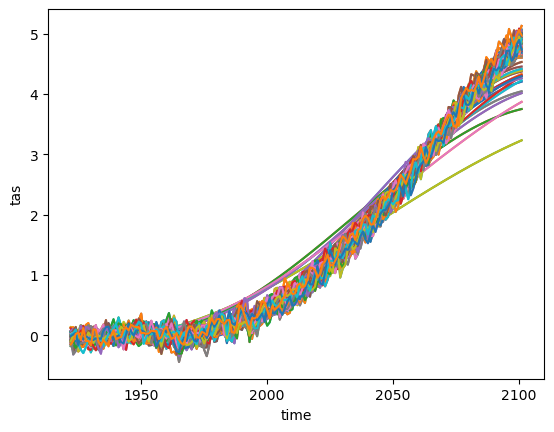

In [229]:
imf_ds.plot(hue='member', add_legend=False);
le_smean_ds.plot(hue='member', add_legend=False);

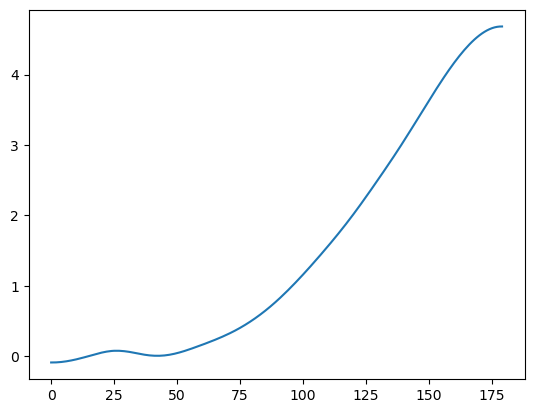

In [215]:
plt.plot(imf_arr[-1, :])

In [212]:
imf_arr.shape

(4, 180)

In [207]:
le_smean_ds

<xarray.DataArray 'tas' (member: 81, time: 180)> Size: 117kB
array([[-0.00697927,  0.06993293,  0.10298288, ...,  4.78752654,
         5.02293365,  5.01599899],
       [-0.07411831, -0.16820097, -0.08162706, ...,  4.79332332,
         4.96340922,  4.94127226],
       [ 0.04616109,  0.04655067,  0.03181169, ...,  4.89266694,
         4.82770904,  4.85744818],
       ...,
       [ 0.01308355,  0.04016984,  0.09747407, ...,  4.68736193,
         4.7464629 ,  4.91824325],
       [-0.01273603,  0.01522133,  0.04351548, ...,  4.82202825,
         4.8960317 ,  4.7325855 ],
       [-0.15100933, -0.09224692,  0.02376789, ...,  4.96772163,
         5.06230821,  4.97347965]])
Coordinates:
  * member   (member) <U7 2kB 'r21i1p1' 'r26i1p1' ... 'r28i1p1' 'r40i1p1'
  * time     (time) object 1kB 1921-12-31 00:00:00 ... 2100-12-31 00:00:00